In [1]:
from platform import python_version
print(python_version())

3.6.8


# Imports

In [3]:
import inspect
import logging
import os
import sys
import io
import re
import pandas as pd
import numpy as np
import nltk
import subprocess
import yaml
import seaborn as sns
from math import *

from matplotlib import pyplot as plt
import matplotlib.cm as cm


# PDFMiner
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.pdfpage import PDFPage
from pdfminer.layout import LAParams

# Collections
import collections
from collections import Counter

# NLTK
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.cluster import KMeansClusterer, euclidean_distance

# Gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models import word2vec

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Spacy
import spacy
nlp = spacy.load('fr_core_news_sm')
# creuser la présence de mot anglais

# Import for progress bar
from tqdm import tqdm


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

# Vars & Paths

In [4]:
AO_directory = "data/input/AO"
DC_directory = "data/input/DC"

AO_output_directory = "data/output/AO"
AO_save_file = "AO_save_file.csv"

DC_output_directory = "data/output/DC"
DC_save_file = "DC_save_file.csv"

confs_path = "confs/config.yaml"
confs = yaml.load(open(confs_path))

C:\Users\ncharbit\AppData\Local\Continuum\anaconda3\envs\p36NLP\lib\site-packages\ipykernel_launcher.py:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # This is added back by InteractiveShellApp.init_path()


In [5]:
# Delete french stopwords
isDeleteFrenchStopwords = False

# Delete english stopwords
isDeleteEnglishStopwords = False 

#lower the word
isLower = True

#lemmatize the word
isLemmatize = False

perplexity=30

possibilities = [False, True]

perplexityPossibilities=[30, 50]

# Extract & Convert into PDF

In [6]:
def convert_pdf(path):
    
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    
    with open(path, "rb") as fp:
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()

        for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                      password=password,
                                      caching=caching,
                                      check_extractable=True):
            interpreter.process_page(page)

        text = retstr.getvalue()

        fp.close()
        device.close()
        retstr.close()
        
    return text



def extract(directory):

    # Reference variables
    file_agg = list()

    # Create list of candidate files
    for root, subdirs, files in os.walk(directory):
        folder_files = map(lambda x: os.path.join(root, x), files)
        file_agg.extend(folder_files)

    # Convert list to a pandas DataFrame
    observations = pd.DataFrame(data=file_agg, columns=['file_path'])
    observations['extension'] = observations['file_path'].apply(lambda x: os.path.splitext(x)[1])
    observations['text'] = observations['file_path'].apply(convert_pdf)
    
    return observations


In [7]:
AO_observations = extract(AO_directory)
DC_observations = extract(DC_directory)

# Save Extracted & Converted files into CSV

In [8]:
def save(observations, output_directory, save_file):

    output_path = os.path.join(output_directory, save_file)
    observations.to_csv(path_or_buf=output_path, index_label='index')
    
    return

In [9]:
save(AO_observations, AO_output_directory, AO_save_file)
save(DC_observations, DC_output_directory, DC_save_file)

# Usefull function

In [10]:
def reduceDimensionList (my_list) :
    
    my_list = [item for sublist in my_list for item in sublist]
    
    return my_list

In [11]:
def getColumn(start_index, end_index, sentences):

        start_index = start_index + 1
        
        if end_index == 0 :
            text = sentences[start_index:]
        else : 
            text = sentences[start_index:end_index]
                        
            
        text = [word_tokenize(w) for w in text]

        my_text = []
        for sent in text :
            my_sent = []
            for word in sent :
                # Delete date or phone number
                if not len(re.findall("[a-zA-Z]",word)) > 0: 
                    continue
                    
                # Delete french stopwords
                if isDeleteFrenchStopwords and (word in stopwords.words("french")):
                    continue
                
                # Delete english stopwords
                if isDeleteEnglishStopwords and (word in stopwords.words("english")):
                    continue
                
                #lower the word
                if isLower:    
                    word = word.lower()
                
                #lemmatize the word
                if isLemmatize:
                    word = nlp(word)[0].lemma_ 
                   
                #append (or not) the word to the "sentence"
                if len(word) > 0:
                    my_sent.append(word)

            #append (or not) the sentence to the "text"
            if len(my_sent) > 0:
                my_text.append(my_sent)
                
        
        return my_text

# Start preprocessing

In [12]:
def preprocessingAO(observations):  
       
    observations['sentences'] = ""
    observations['sentences2'] = ""

    for index, row in tqdm(observations.iterrows()):
        
        # Tokenization
        sentences = []        
        del_1 = "\n"
        delimiters = del_1 
        paragraphs = [p for p in re.split(delimiters, row["text"]) if p]
        for paragraph in paragraphs:
            sentences += sent_tokenize(paragraph)
        observations.loc[index, "sentences"] = sentences
        
        observations.loc[index, "sentences2"] = getColumn(0, 0, sentences)

        
    return observations


def preprocessingDC(observations):  
    
    observations['sentences'] = ""
    observations['sentences2'] = ""
    observations['skills'] = ""
    observations['exp'] = ""
    observations['formation'] = ""
    
        
    for index, row in tqdm(observations.iterrows()):
        
        # Tokenization
        sentences = []        
        del_1 = "JEMS - \d.*.com"
        del_2 = "Votre contact JEMS .* \n"
        del_3 = "\n"
        #del_4 = "\/"
        delimiters = del_1 + '|' + del_2 + '|' + del_3# + '|' + del_4
        paragraphs = [p for p in re.split(delimiters, row["text"]) if p]
        for paragraph in paragraphs:
            sentences += sent_tokenize(paragraph)
        observations.loc[index, 'sentences'] = sentences
        
        
        # Get index
        list_index_synthese = ['SYNTHESE DE COMPETENCES']
        list_index_experience = ['EXPERIENCES PROFESSIONNELLES', 'EXPERIENCE PROFESSIONNELLE']
        list_index_formation = ['FORMATIONS', 'FORMATION', "DIPLOMES & FORMATIONS"]
        for i,e in enumerate(sentences):
            if e in list_index_synthese:
                index_synthese = i
            elif e in list_index_experience:
                index_experience = i
            elif e in list_index_formation:
                index_formation = i

        
        # Get Section By Section
        dictionnaryIndex = {
            "skills" : index_synthese,
            "exp" : index_experience,
            "formation" : index_formation}       
        listofTuples = sorted(dictionnaryIndex.items(), key=lambda x: x[1])
        for i in range(len(listofTuples)):
            k = listofTuples[i][0]
            v = int(listofTuples[i][1])
            
            v2 = 0
            if i < len(listofTuples) - 1:
                k2 = listofTuples[i+1][0]
                v2 = int(listofTuples[i+1][1])
            
            
            observations.loc[index, k] = getColumn(v, v2, sentences)
            
        observations.loc[index, "sentences2"] = getColumn(0, 0, sentences)
        
    return observations

In [13]:
AO_observations = preprocessingAO(AO_observations)
DC_observations = preprocessingDC(DC_observations)

18it [00:00, 49.75it/s]
23it [00:01, 12.43it/s]


In [14]:
#print(AO_observations)
#print(DC_observations)

In [15]:
#print(AO_observations.loc[0, 'sentences'])
#print(AO_observations.loc[0, 'sentences2'])

In [16]:
#print(DC_observations.loc[0, 'text'])
#print(DC_observations.loc[0, 'sentences'])
#print(DC_observations.loc[0, 'sentences2'])
#print(DC_observations.loc[0, 'skills'])

# Visualize text

In [17]:
def Display(observations, column, threshold) :

    allTexts = reduceDimensionList(observations[column].tolist())
    allTexts = reduceDimensionList(allTexts)
    
    
    # Display len of words
    test = [len(w) for w in allTexts]
    print("Display len of words : ")
    print(test)
    plt.hist(test)
    plt.show()


    # Write word with len > 15
    test = [w for w in allTexts if len(w)>15]
    if (len(test) > 0):
        print("Display words where len>15 : ")
        print(test)


    # Write & Display word frequency >= threshold
    test = Counter(allTexts)
    test = {x : test[x] for x in test if test[x] >= threshold}
    
    print("Display frequency of words : ")
    print(test)
    
    labels, values = zip(*test.items())
    indexes = np.arange(len(labels))
    width = 1
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

In [18]:
#Display(AO_observations, 'sentences2', 5)
#Display(DC_observations, 'skills', 4)
#Display(DC_observations, 'exp',20)
#Display(DC_observations, 'formation', 6)

# Dummy NLP

In [19]:
def term_count(string_to_search, term):
    try:
        term = r'\b' + re.escape(term) + r'\b'
        regular_expression = re.compile(term, re.IGNORECASE)
        result = re.findall(regular_expression, string_to_search)
        return len(result)
    except Exception:
        logging.error('Error occurred during regex search')
        return 0


def term_match(string_to_search, term):
    try:
        term = r'\b' + re.escape(term) + r'\b'
        regular_expression = re.compile(term, re.IGNORECASE)
        result = re.findall(regular_expression, string_to_search)
        if len(result) > 0:
            return result[0]
        else:
            return None
    except Exception:
        logging.error('Error occurred during regex search')
        return None


In [20]:
def extract_skills(resume_text, extractor, items_of_interest):
    potential_skills_dict = dict()
    matched_skills = set()

    # Translate the YAML file into a dic : potential_skills_dict
    for skill_input in items_of_interest:

        # Format list inputs
        if type(skill_input) is list and len(skill_input) >= 1:
            potential_skills_dict[skill_input[0]] = skill_input

        # Format string inputs
        elif type(skill_input) is str:
            potential_skills_dict[skill_input] = [skill_input]
        else:
            logging.warn('Unknown skill listing type: {}. Please format as either a single string or a list of strings'
                         ''.format(skill_input))

    for (skill_name, skill_alias_list) in potential_skills_dict.items():

        skill_matches = 0
        # Iterate through aliases
        for skill_alias in skill_alias_list:
            # Add the number of matches for each alias
            skill_matches += term_count(resume_text.lower(), skill_alias.lower())
            

        # If at least one alias is found, add skill name to set of skills
        if skill_matches > 0:
            matched_skills.add(skill_name)

    return matched_skills

In [21]:
def extract_fields(df):
    for extractor, items_of_interest in confs['extractors'].items():
        df[extractor] = df['text'].apply(lambda x: extract_skills(x, extractor, items_of_interest))
    return df

In [22]:
DC_observations = extract_fields(DC_observations)
AO_observations = extract_fields(AO_observations)

In [23]:
#print(DC_observations)
#print(AO_observations)

# Scoring ?

In [37]:
my_AO_nb = 10
my_AO = AO_observations.loc[my_AO_nb, "Experience":].to_frame()

In [38]:
my_AO

,10
Experience,{}
Platforms,{}
Database,{SQL}
DataWarehouse,{}
DataVisualisation,{Tableau}
DevOps,{}
Cloud,{}
Programming,{}
Methodologie,{}
MachineLearning,{}


In [39]:
# Construit un DataFrame contenant que les labels utiles
labels = []
for index, row in my_AO.iterrows():
    
    # Les listes vides ne nous interessent pas
    if len(row[my_AO_nb]) == 0:
        continue
        
    labels.append(index)
    
test = DC_observations.copy()
test = test[labels]


# Compare les éléments présent dans l'AO et le CV
for dc_index, dc_row in test.iterrows():
    
    for col in test:
        
        counter = 0
        for item in my_AO.loc[col][my_AO_nb] :
                        
            if item in dc_row[col]:
                counter = counter + 1

        dc_row[col] = counter / len(my_AO.loc[col][my_AO_nb])


# Display

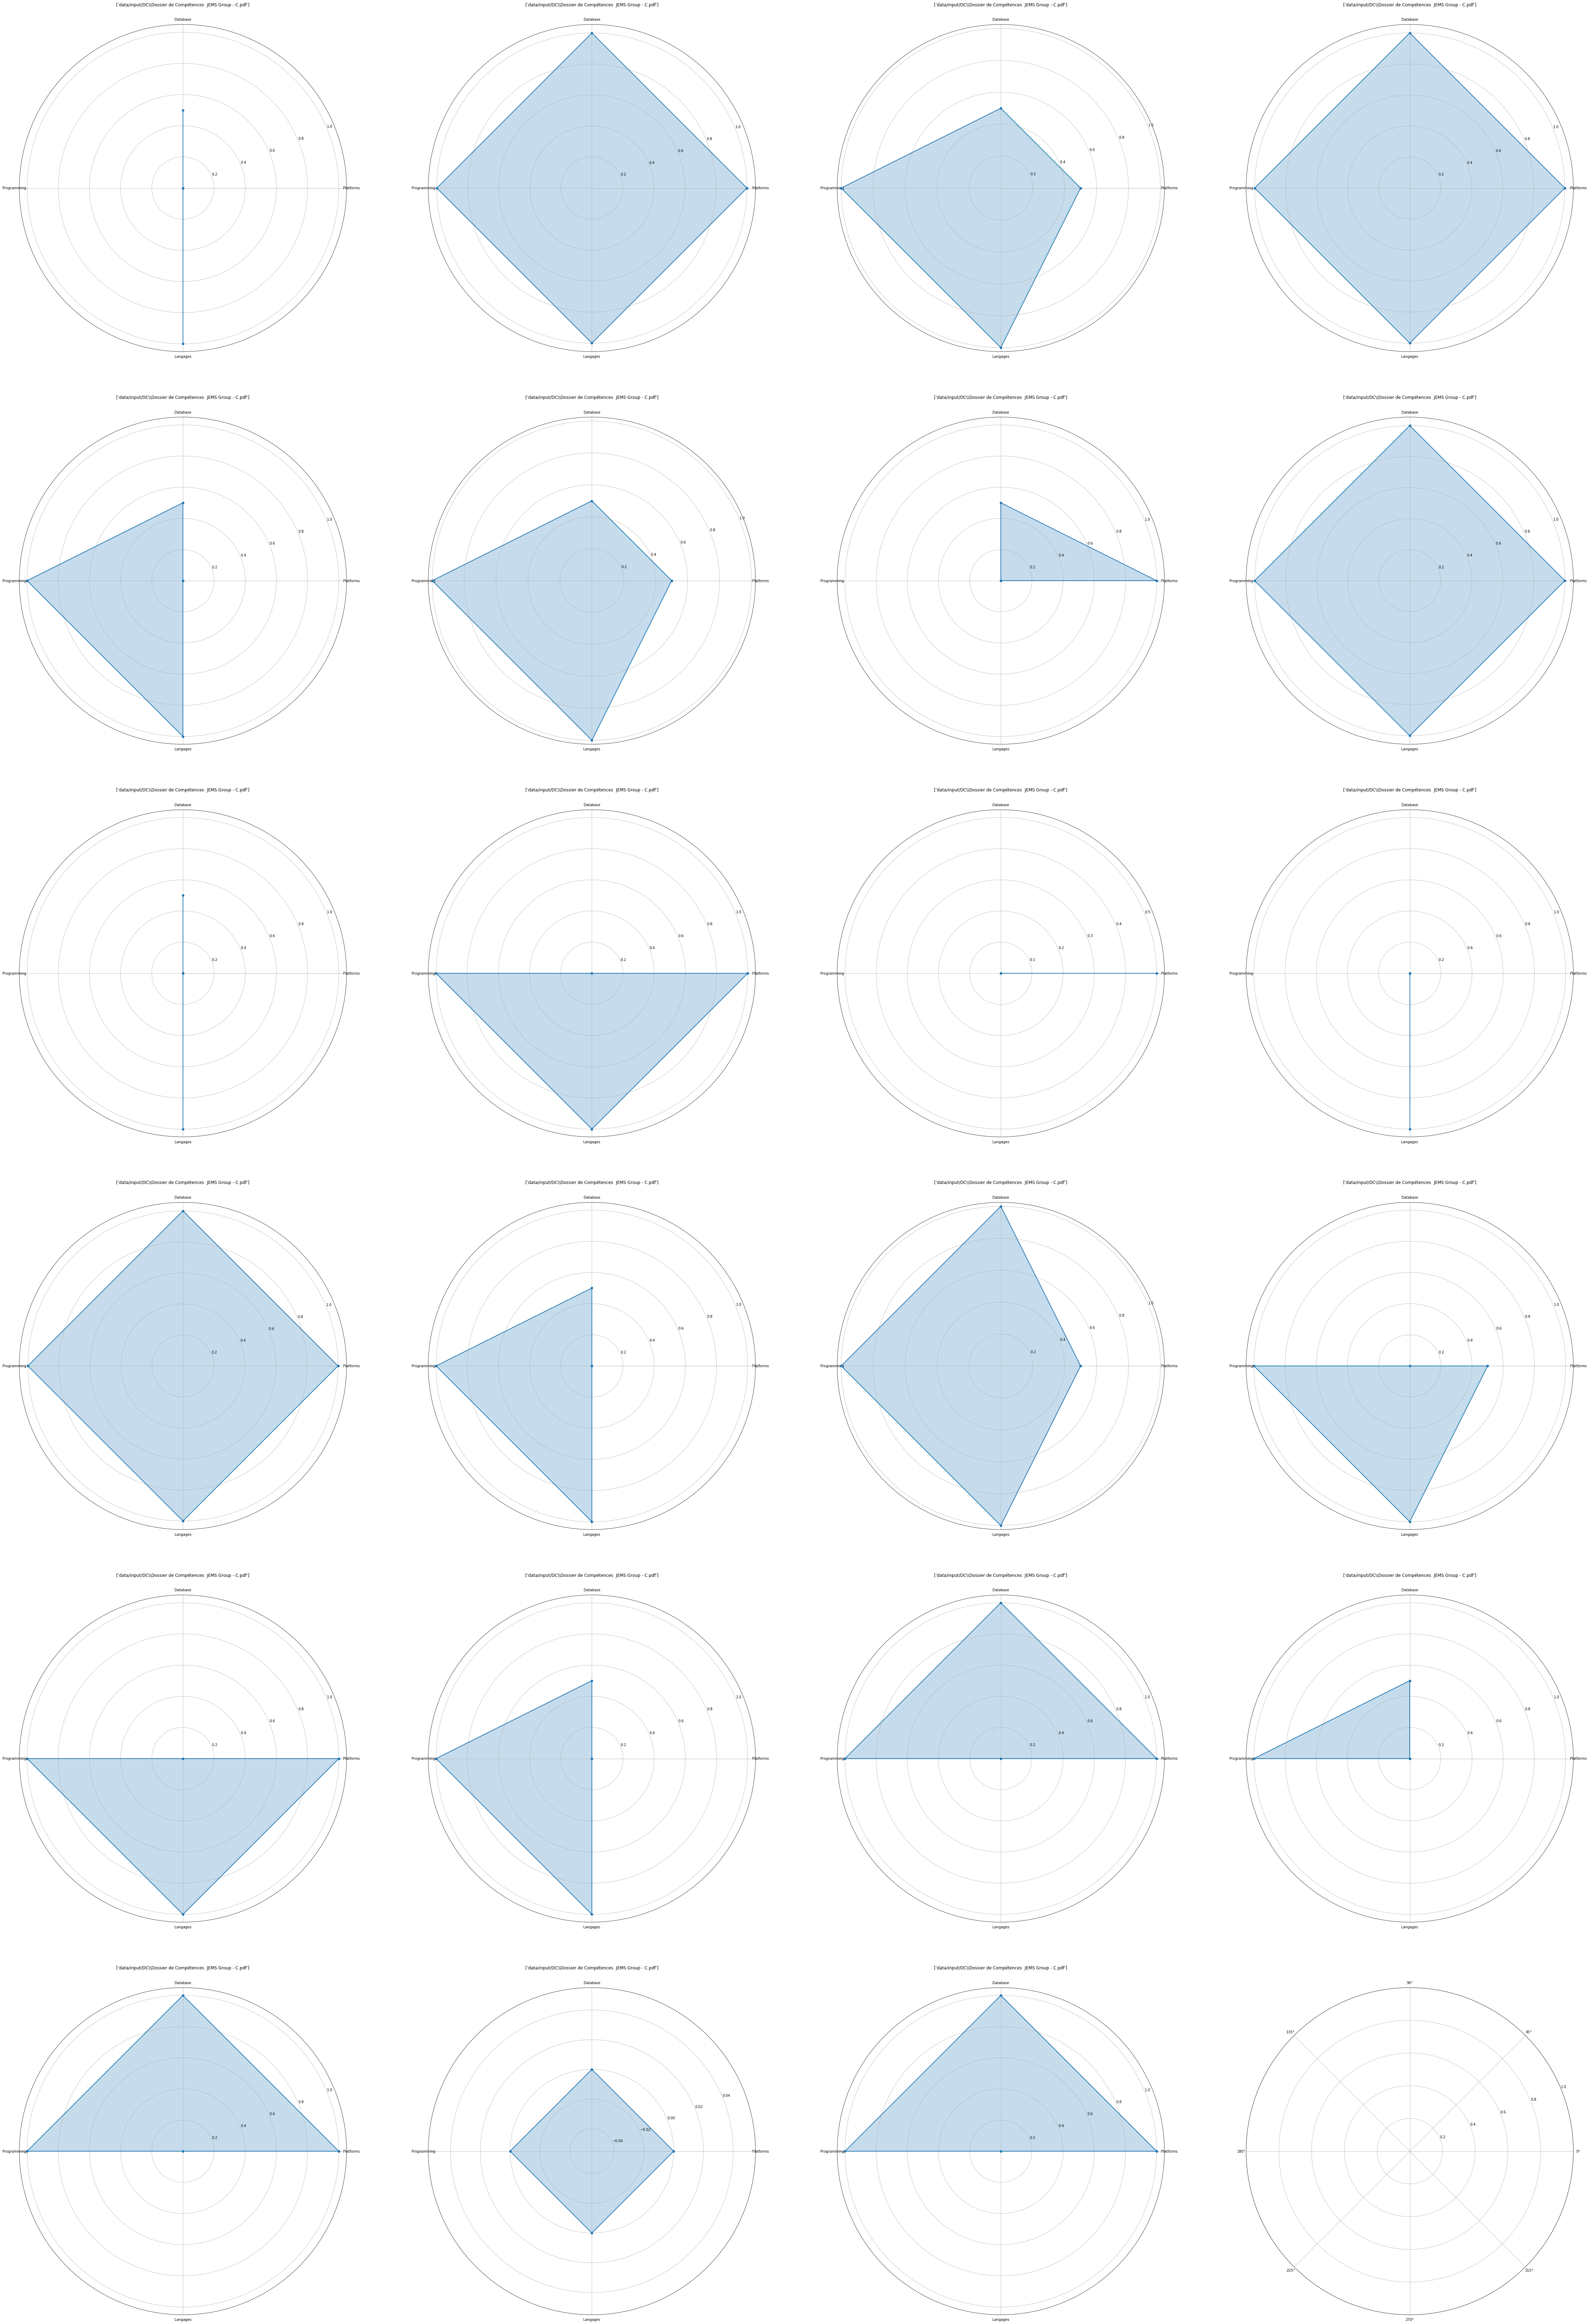

In [26]:
nCols = 4
nRows = ceil(len(test) / nCols)
i = 0

fig, axs = plt.subplots(nRows, nCols, figsize=(nCols * 20, nRows * 20), subplot_kw=dict(projection='polar'))

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))


for r in range(nRows) :
    for c in range(nCols):

        if (i >= len(test)):
            break
            
        stats=test.loc[i,labels].values
        stats=np.concatenate((stats,[stats[0]]))


        axs[r, c].plot(angles, stats, 'o-', linewidth=2)
        axs[r, c].fill(angles, stats, alpha=0.25)
        axs[r, c].set_thetagrids(angles * 180/np.pi, labels)
        axs[r, c].set_title([DC_observations.loc[0,"file_path"]])
        axs[r, c].grid(True)
    

        i = i+1

# Final Result

In [27]:
a = test.mean(axis = 1, skipna = True)
a = a.sort_values(ascending = False)
a.keys()

Int64Index([ 1, 12,  3,  7, 14, 22,  5, 20, 18, 16,  2,  9, 17, 15, 13,  4,  0,
             6,  8, 19, 11, 10, 21],
           dtype='int64')

In [28]:
DC_observations.iloc[a.keys()]

,file_path,extension,text,sentences,sentences2,skills,exp,formation,Experience,Platforms,...,DataWarehouse,DataVisualisation,DevOps,Cloud,Programming,Methodologie,MachineLearning,Mobile,Langages,Open-source
1,data/input/DC\Dossier de compétences de JEMS ...,.pdf,RHA \n\nConsultant BIG DATA \n\nSYNTHESE DE CO...,"[RHA, Consultant BIG DATA, SYNTHESE DE COMPETE...","[[consultant, big, data], [synthese, de, compe...","[[savoir-faire], [connaissance, de, l, écosyst...","[[depuis, avril, jems, datafactory], [mai, aou...","[[diplôme, d, ingénieur, en, génie, mathématiq...",{},"{Unix, Windows}",...,{},"{Tableau, Qlik, PowerBI}",{},{},"{R, Python, java}",{},{},{},{English},{}
12,data/input/DC\Dossier de Compétences JEMS - H...,.pdf,1 \n\n \n\n \n\n \n\nExpert Big Data ...,"[1, Expert Big Data, SYNTHESE DE COMPETENCES, ...","[[expert, big, data], [synthese, de, competenc...","[[compétences, fonctionnelles], [big, data, ma...","[[depuis, octobre, jems, group], [expertise, b...","[[certification, hdp], [formations, bigdata, c...",{Developer},"{Unix, Windows}",...,"{Apache Hadoop, Kafka, HIVE, MapReduce, Postgr...",{Qlik},"{Jenkins, SonarQube, Maven, Nexus, IntelliJ}",{},"{Perl, PHP, Python, R, JavaScript, C, java, Sc...","{Agile, Lean}",{},{},{English},{gitlab}
3,data/input/DC\Dossier de compétences JEMS - ...,.pdf,\n\n \n \n\n \n\n \n\n \n\n \n\n \n \n\n \n\n...,"[Ingénieur d’études confirmé ASP.Net / C#, 7 a...","[[ans, d, expérience], [formation], [master, s...","[[sonarqube], [serveur, d, application, iis, a...","[[mai, décembre, préfecture, de, rabat, minist...","[[master, scientifique, msc, option, managemen...",{},"{Android, Unix, Windows}",...,{},{},"{Maven, SonarQube}",{},"{java, C, .NET}","{Cycle en V, Agile}",{},{Android},"{Spanish, English}",{}
7,data/input/DC\Dossier de Compétences JEMS - D...,.pdf,1 \n\n \n\n \n\nDK \n\nConsultant Big Data \n\...,"[1, DK, Consultant Big Data, SYNTHESE DE COMPE...","[[dk], [consultant, big, data], [synthese, de,...","[[compétences, techniques], [programmation], [...","[[février, février, data, scientist, engineer,...","[[juin], [baccalauréat, grec, apolytirion, lyc...","{DataEngineer, DataScientist}","{Unix, Windows}",...,"{Apache Hadoop, PIG, Apache Spark, HIVE}",{Tableau},{},{},"{Matlab, Python, R, C, java, Swift}",{},"{keras, sklearn}",{},"{Spanish, English}",{gitlab}
14,data/input/DC\Dossier de Compétences JEMS - N...,.pdf,1 \n\n \n\n \n\nNZE \n\nCONSULTANT TAL...,"[1, NZE, CONSULTANT TALEND / QLIK SENSE / QLIK...","[[nze], [consultant, talend, qlik, sense, qlik...","[[mise, en, œuvre, et, maintenance, d, applica...","[[de, novembre, a, ajourd, hui, veolia, water,...","[[formation, servicenow, jira], [formation, go...",{},"{IOS, Android, Windows}",...,{Postgress},"{SAS, Qlik}",{},{Google Cloud Platform},"{PHP, Python, JavaScript, C, java}",{},{},"{IOS, Android}",{English},{}
22,data/input/DC\Dossier de Compétences JEMS Gro...,.pdf,\n\n \n\n \n\n \n\nConsultant Big Da...,"[Consultant Big Data, 1, SYNTHESE DE COMPETENC...","[[synthese, de, competences], [savoir-faire], ...","[[savoir-faire], [recueil, du, besoin, métier,...","[[depuis, avril, sephora], [chef, de, projet, ...","[[test, des, différentes, solutions, d, intégr...",{DataScientist},"{Mac, Unix, Windows}",...,"{Apache Hadoop, MapReduce, HIVE, Apache Spark}","{Tableau, Qlik}","{Jenkins, Maven}","{AWS, Google Cloud Platform}","{PHP, Python, R, JavaScript, C, java, Scala}",{Agile},{},{},{},{}
5,data/input/DC\Dossier de Compétences JEMS - A...,.pdf,1 \n\n \n\n \n\n \n\n \n \n\n \n\n \n\...,"[1, Développeur Fullstack, 6 années d’expérien...","[[développeur, fullstack], [années, d, expérie...","[[métiers], [fonctionnelles], [etudes, transve...","[[novembre, mars], [développeur, full, stack, ...",[],{},"{IOS, Android, Windows}",...,{Postgress},{},{},{AWS},"{JavaScript, java, C}",{Agile},{},"{IOS, Windows Phone, Android}","{German, English}",{}
20,data/input/DC\Dossier de Compétences JEMS -A.pdf,.pdf,1 \n\n \n\n \n\n \n\n. \n\nCon

# All cases

In [ ]:
AO_extract = extract(AO_directory)
DC_extract = extract(DC_directory)

for perplexity in perplexityPossibilities :
    for isDeleteFrenchStopwords in possibilities :
        for isDeleteEnglishStopwords in possibilities :
            for isLower in possibilities :
                for isLemmatize in possibilities :

                    print("preprocessing")

                    # Preprocessing datas
                    AO_observations = preprocessingAO(AO_extract)
                    DC_observations = preprocessingDC(DC_extract)

                    title = "Mincount_10" \
                    + " Files_" + str(len(DC_observations) + len(AO_observations)) \
                    + " Perplexity" + str(perplexity) \
                    + " FrenchStopword_" + str(isDeleteFrenchStopwords) \
                    + " EnglishStopword_" + str(isDeleteEnglishStopwords) \
                    + " Lower_" + str(isLower) \
                    + " Lemmatization_" + str(isLemmatize) \
                    + ".png"

                    print (title)



                    # Concat AO & DC
                    listToReduce = AO_observations['sentences2'].tolist() + DC_observations['sentences2'].tolist()

                    print("corpus")
                    # Plot model and save fig
                    corpus = reduceDimensionList(listToReduce)
                    model = word2vec.Word2Vec(corpus, min_count=20, seed = 0)

                    print("plot")
                    tsne_plot(model)

# Others preprocessing

In [ ]:
def preprocessingGensim(observations):
    logging.info('Begin preprocessingGensim')
    
    
    observations['tf-idf'] = ""

    
    # Create a Corpus
    dictionary = Dictionary(observations["lemmatized"].tolist())
    corpus = [dictionary.doc2bow(text) for text in observations['lemmatized'].tolist()]
        
    # Create a new TfidfModel using the corpus
    tfidf = TfidfModel(corpus)
    
    for index, row in observations.iterrows():
        
        tfidf_weights = tfidf[corpus[index]]
        sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
        observations.loc[index, 'tf-idf'] = sorted_tfidf_weights
        

    logging.info('End preprocessingGensim')
    return observations

In [ ]:
def preprocessingSpacy(observations):
    logging.info('Begin preprocessingSpaCy')
    
    
    observations['nlp'] = ""
    
    # Instantiate the nlp
    nlp = spacy.load('en_core_web_sm')
        
    for index, row in observations.iterrows():
        
        # Tokenization
        nlp = nlp(observations.loc[index, 'text'])
        observations.loc[index, 'nlp'] = nlp

    
    logging.info('End preprocessingSpaCy')
    return observations

In [29]:
AO_observations

,file_path,extension,text,sentences,sentences2,Experience,Platforms,Database,DataWarehouse,DataVisualisation,DevOps,Cloud,Programming,Methodologie,MachineLearning,Mobile,Langages,Open-source
0,data/input/AO\AO JEMS group-2.pdf,.pdf,\n \nContexte détaillé de la Mission \n \nDom...,"[Contexte détaillé de la Mission, Domaine, Env...","[[domaine], [environnement, technique, général...",{},"{Unix, Windows}","{Oracle, SQL}",{},{},{},{},{java},{},{},{},{English},{}
1,data/input/AO\Ao--05-07-2016-812632-001.pdf,.pdf,Document de consultation Appel d’offres\n\n \n...,"[Document de consultation Appel d’offres, Info...","[[informations, relatives, l, appel, d, offres...",{},{},{},{},{},{},{},{},{},{},{},{English},{}
2,data/input/AO\Ao--10-11-2015-496231-001.pdf,.pdf,Document de consultation Appel d’offres\n\nInf...,"[Document de consultation Appel d’offres, Info...","[[informations, relatives, l, appel, d, offres...",{},"{Unix, Windows}","{Oracle, SQL}",{},{},{},{},{},{},{},{},{English},{}
3,data/input/AO\Ao--20-06-2016-201696-001.pdf,.pdf,Document de consultation Appel d’offres\n\n \n...,"[Document de consultation Appel d’offres, Info...","[[informations, relatives, l, appel, d, offres...",{},{Unix},{SQL},{},{},{},{},{},{},{},{},{English},{}
4,data/input/AO\Ao--20-10-2011-361638-001.pdf,.pdf,Document de consultation Appel d’offres\n\nInf...,"[Document de consultation Appel d’offres, Info...","[[informations, relatives, l, appel, d, offres...",{},{},"{Oracle, SQL}",{},{},{},{},{java},{},{},{},{English},{}
5,data/input/AO\Ao--25-02-2014-536631-001.pdf,.pdf,Document de consultation Appel d’offres\n\nInf...,"[Document de consultation Appel d’offres, Info...","[[informations, relatives, l, appel, d, offres...",{},{Unix},{SQL},{},{},{},{},{},{},{},{},{English},{}
6,data/input/AO\Ao--26-07-2016-352422-001.pdf,.pdf,Document de consultation Appel d’offres\n\n \n...,"[Document de consultation Appel d’offres, Info...","[[informations, relatives, l, appel, d, offres...",{},{},{SQL},{},{},{},{},{C},{},{},{},{English},{}
7,data/input/AO\AO-Br--25-03-2010-182482-001.pdf,.pdf,Document de consultation Appel d’offre\n\nInfo...,"[Document de consultation Appel d’offre, Infor...","[[informations, relatives, l, appel, d, offre]...",{},{},{},{},{},{},{},{},{},{},{},{English},{}
8,data/input/AO\BNPPAM_AO_2018-45992 - PMO for s...,.pdf,REQUEST FOR PROPOSAL/ APPEL D’OFFRE 2018-45992...,[REQUEST FOR PROPOSAL/ APPEL D’OFFRE 2018-4599...,"[[mission/, mission], [category/, catégorie], ...",{},{},{},{},{},{},{},{},{Agile},{},{},{English},{}
9,data/input/AO\BNPPAM_AO_2018-46103 - Senior AP...,.pdf,REQUEST FOR PROPOSAL/ APPEL D’OFFRE 2018-46103...,[REQUEST FOR PROPOSAL/ APPEL D’OFFRE 2018-4610...,"[[mission/, mission], [category/, catégorie], ...",{Developer},{},"{Oracle, SQL, MySQL, NoSQL}",{},{},{},{},{java},{Agile},{},{},{English},{}
